# NOTEBOOK 03: TẠO DATAFRAME TƯƠNG LAI (DataFrame 3)

**Mục tiêu:** Tạo file `03_future_dataframe.csv`.
File này chứa "kịch bản" (scenario) cho 16 tuần tới, dùng làm đầu vào (input) cho `model.predict()`.

**Quy trình:**
1.  Kết nối Google Drive.
2.  Tải dữ liệu lịch sử (`10_sparkplug_dataset_final.csv`) từ Drive để làm cơ sở.
3.  Tạo các "Sub-model" (model con) để dự báo các feature có xu hướng/mùa vụ.
4.  Điền các giá trị "Kế hoạch" (Promo, Giá) và "Giả định" (GDP, Logistics).
5.  Tính toán các feature phái sinh (`new_ice...`, `total_on_road...`).
6.  Lưu file `03_future_dataframe.csv` đã hoàn thiện trở lại Drive.

In [ ]:
!pip install prophet --upgrade

In [ ]:
# Cài thư viện Prophet nếu cần
# !pip install prophet

import pandas as pd
import numpy as np
from prophet import Prophet
import warnings
import os
from google.colab import drive

warnings.filterwarnings('ignore', category=FutureWarning)
print("Các thư viện đã sẵn sàng.")

Các thư viện đã sẵn sàng.


In [ ]:
print("--- 1. Kết nối Google Drive ---")
try:
    drive.mount('/content/drive')
    print("✅ Google Drive đã kết nối.")
except Exception as e:
    print(f"❌ LỖI: Không thể kết nối Google Drive: {e}")
    raise

# --- CẤU HÌNH ĐƯỜNG DẪN ---
# Giả sử bạn đã lưu mọi thứ trong thư mục "Denso_Synthetic_Data"
BASE_DRIVE_PATH = "/content/drive/MyDrive/Denso/Data_Structure/"

# File Input (Lịch sử)
HISTORY_FILE_PATH = os.path.join(BASE_DRIVE_PATH, "10_sparkplug_dataset_final.csv")

# File Output (Tương lai)
FUTURE_FILE_PATH = os.path.join(BASE_DRIVE_PATH, "03_future_dataframe.csv")

print(f"Sẽ đọc lịch sử từ: {HISTORY_FILE_PATH}")
print(f"Sẽ lưu tương lai vào: {FUTURE_FILE_PATH}")

--- 1. Kết nối Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive đã kết nối.
Sẽ đọc lịch sử từ: /content/drive/MyDrive/Denso/Data_Structure/10_sparkplug_dataset_final.csv
Sẽ lưu tương lai vào: /content/drive/MyDrive/Denso/Data_Structure/03_future_dataframe.csv


In [ ]:
print("--- 2. Tải Dữ liệu Lịch sử (Làm cơ sở) ---")
try:
    df_history = pd.read_csv(HISTORY_FILE_PATH, parse_dates=["ds"])
    df_history = df_history.sort_values(by='ds')
    print(f"✅ Đã tải {len(df_history)} dòng dữ liệu lịch sử.")
    print(f"Dữ liệu lịch sử kết thúc vào: {df_history['ds'].max().date()}")
except FileNotFoundError:
    print(f"❌ LỖI: Không tìm thấy '{HISTORY_FILE_PATH}'.")
    print("Vui lòng chạy notebook sinh dữ liệu (PART 1-5) trước và lưu vào Drive.")
    raise

--- 2. Tải Dữ liệu Lịch sử (Làm cơ sở) ---
✅ Đã tải 202 dòng dữ liệu lịch sử.
Dữ liệu lịch sử kết thúc vào: 2025-11-10


In [ ]:
print("--- 3. Cấu hình Dự báo & Tạo DataFrame Tương lai (Rỗng) ---")
FORECAST_WEEKS = 16 # Dự báo cho 16 tuần tới
FREQ = "W-MON"

last_date = df_history["ds"].max()

# Tạo trục thời gian tương lai
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=7),
    periods=FORECAST_WEEKS,
    freq=FREQ
)
future_df = pd.DataFrame({"ds": future_dates})
print(f"Sẽ tạo DataFrame 3 cho {FORECAST_WEEKS} tuần (từ {future_dates.min().date()} đến {future_dates.max().date()}).")

# Lấy danh sách TẤT CẢ các feature
FEATURES = [col for col in df_history.columns if col not in ['y', 'y_oem', 'y_aftermarket', 'y_true', 'ds']]
print(f"Đã xác định {len(FEATURES)} features để điền.")

--- 3. Cấu hình Dự báo & Tạo DataFrame Tương lai (Rỗng) ---
Sẽ tạo DataFrame 3 cho 16 tuần (từ 2025-11-17 đến 2026-03-02).
Đã xác định 20 features để điền.


In [ ]:
print("--- 4. Chạy Sub-model để Dự báo các feature có Xu hướng/Mùa vụ ---")

# === 4a. Sub-model cho 'total_new_vehicle_sales' (Mùa vụ) ===
# Feature này có tính mùa vụ (Tết, Ngâu) rất mạnh, không thể "giữ nguyên"
print(" -> Đang huấn luyện Sub-model cho 'total_new_vehicle_sales'...")
m_sales = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
# Huấn luyện chỉ trên 2 cột này (đổi tên y)
m_sales.fit(df_history[['ds', 'total_new_vehicle_sales']].rename(columns={'total_new_vehicle_sales':'y'}))
# Dự báo tương lai
future_sales = m_sales.predict(future_df[['ds']])
# Gán vào DataFrame 3
future_df['total_new_vehicle_sales'] = future_sales['yhat'].values.clip(0).astype(int) # clip(0) để đảm bảo không âm

# === 4b. Sub-model cho 'bev_penetration_rate' (Xu hướng) ===
# Feature này có xu hướng "hockey stick" (bùng nổ), không thể "giữ nguyên"
print(" -> Đang huấn luyện Sub-model cho 'bev_penetration_rate'...")
m_bev = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
# Huấn luyện chỉ trên 2 cột này
m_bev.fit(df_history[['ds', 'bev_penetration_rate']].rename(columns={'bev_penetration_rate':'y'}))
# Dự báo tương lai
future_bev = m_bev.predict(future_df[['ds']])
# Gán vào DataFrame 3
future_df['bev_penetration_rate'] = future_bev['yhat'].values.clip(0, 1) # clip(0, 1) để đảm bảo tỷ lệ 0-1

print(" -> Đã dự báo xong 2 feature bằng Sub-model.")

--- 4. Chạy Sub-model để Dự báo các feature có Xu hướng/Mùa vụ ---
 -> Đang huấn luyện Sub-model cho 'total_new_vehicle_sales'...
 -> Đang huấn luyện Sub-model cho 'bev_penetration_rate'...
 -> Đã dự báo xong 2 feature bằng Sub-model.


--- 4c. Trực quan hóa kết quả 2 Sub-model ---
 -> Đang vẽ biểu đồ dự báo cho 'total_new_vehicle_sales'...


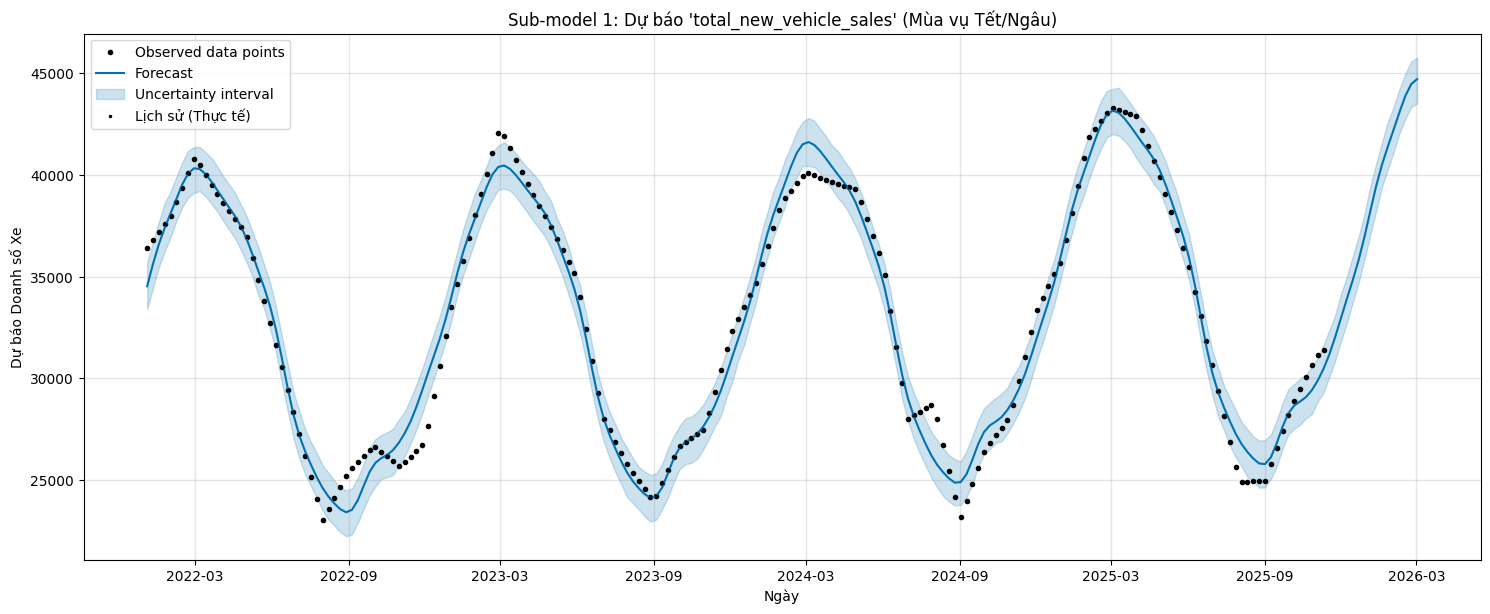

 -> Đang vẽ biểu đồ dự báo cho 'bev_penetration_rate'...


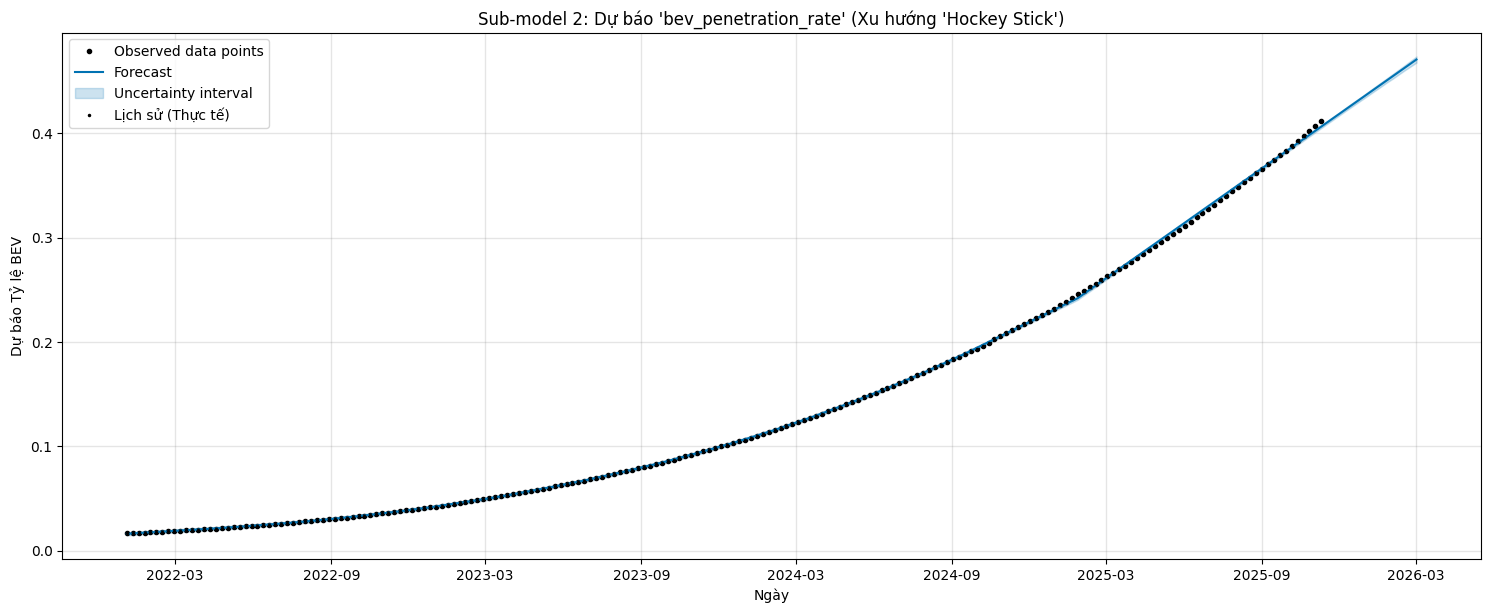

 -> Hoàn tất trực quan hóa sub-model.


In [ ]:
import matplotlib.pyplot as plt

print("--- 4c. Trực quan hóa kết quả 2 Sub-model ---")

# === VẼ BIỂU ĐỒ 1: 'total_new_vehicle_sales' ===
print(" -> Đang vẽ biểu đồ dự báo cho 'total_new_vehicle_sales'...")

# Để vẽ biểu đồ đẹp, chúng ta cần dự báo trên cả LỊCH SỬ + TƯƠNG LAI
full_df_sales = pd.concat([df_history[['ds']], future_df[['ds']]], ignore_index=True)
full_forecast_sales = m_sales.predict(full_df_sales)

# Vẽ biểu đồ dự báo của Prophet
fig1 = m_sales.plot(full_forecast_sales, figsize=(15, 6))
ax1 = fig1.gca()
# Thêm các điểm dữ liệu LỊCH SỬ (thực tế) lên trên
ax1.plot(df_history['ds'], df_history['total_new_vehicle_sales'], 'k.', markersize=3, label='Lịch sử (Thực tế)')
ax1.set_title("Sub-model 1: Dự báo 'total_new_vehicle_sales' (Mùa vụ Tết/Ngâu)")
ax1.set_xlabel("Ngày")
ax1.set_ylabel("Dự báo Doanh số Xe")
ax1.legend()
plt.show()


# === VẼ BIỂU ĐỒ 2: 'bev_penetration_rate' ===
print(" -> Đang vẽ biểu đồ dự báo cho 'bev_penetration_rate'...")

# Dự báo trên cả LỊCH SỬ + TƯƠNG LAI
full_df_bev = pd.concat([df_history[['ds']], future_df[['ds']]], ignore_index=True)
full_forecast_bev = m_bev.predict(full_df_bev)

# Vẽ biểu đồ dự báo của Prophet
fig2 = m_bev.plot(full_forecast_bev, figsize=(15, 6))
ax2 = fig2.gca()
# Thêm các điểm dữ liệu LỊCH SỬ (thực tế) lên trên
ax2.plot(df_history['ds'], df_history['bev_penetration_rate'], 'k.', markersize=3, label='Lịch sử (Thực tế)')
ax2.set_title("Sub-model 2: Dự báo 'bev_penetration_rate' (Xu hướng 'Hockey Stick')")
ax2.set_xlabel("Ngày")
ax2.set_ylabel("Dự báo Tỷ lệ BEV")
ax2.legend()
plt.show()

print(" -> Hoàn tất trực quan hóa sub-model.")

In [ ]:
print("--- 5. Điền các giá trị Kế hoạch (Plan) và Giả định (Assume) ---")

# Lấy giá trị cuối cùng từ lịch sử để làm cơ sở
last_known_values = df_history.iloc[-1]

# Lặp qua tất cả các feature
for f in FEATURES:
    # Bỏ qua các feature đã được Sub-model điền
    if f in ['total_new_vehicle_sales', 'bev_penetration_rate']:
        continue

    # Bỏ qua các feature phái sinh (sẽ tính ở bước sau)
    if f in ['new_ice_and_hybrid_sales', 'total_ice_and_hybrid_on_road']:
        continue

    # Nhóm 1 & 2: Kế hoạch (Bạn sẽ chỉnh sửa phần này hàng tuần)
    if f == 'promo_flag':
        future_df[f] = 0 # Kế hoạch: Không khuyến mãi
    elif f == 'promo_depth':
        future_df[f] = 0 # Kế hoạch: Không khuyến mãi
    elif f == 'holiday_flag':
        future_df[f] = 0 # Giả định: Không có lễ (Cần logic kiểm tra lịch nâng cao)
    elif f == 'stockout_flag':
        future_df[f] = 0 # Mục tiêu: Không hết hàng

    # Nhóm 3: Giả định (Giữ nguyên giá trị cuối)
    # Đây là nơi API/Tavily của bạn sẽ cung cấp 'last_known_value'
    elif f == 'weather_impact_score':
        future_df[f] = 0 # Giả định: Thời tiết tương lai bình thường
    else:
        # Quy tắc chung cho các biến khác (GDP, CPI, Gas, Logistics...): Giữ nguyên
        future_df[f] = last_known_values[f]

print(" -> Đã điền các Kế hoạch và Giả định.")

--- 5. Điền các giá trị Kế hoạch (Plan) và Giả định (Assume) ---
 -> Đã điền các Kế hoạch và Giả định.


In [ ]:
print("--- 6. Tính toán các feature Phái sinh (Drivers chính) ---")

# 1) Tính 'new_ice_and_hybrid_sales'
future_df['new_ice_and_hybrid_sales'] = (
    future_df['total_new_vehicle_sales'] * (1 - future_df['bev_penetration_rate'])
).round(0).astype(int)

# 2) Tính 'total_ice_and_hybrid_on_road' bằng vòng lặp
print(" -> Đang tính toán 'total_ice_and_hybrid_on_road'...")
scrappage_rate_weekly = 0.001
weeks_n = len(future_df)
# Lấy giá trị cuối cùng từ lịch sử làm điểm bắt đầu
last_total_on_road = df_history['total_ice_and_hybrid_on_road'].iloc[-1]
new_sales_future = future_df['new_ice_and_hybrid_sales'].values

total_on_road_future = np.empty(weeks_n, dtype=float)

# Vòng lặp
for i in range(weeks_n):
    # Lấy giá trị của tuần trước (hoặc giá trị cuối cùng của lịch sử)
    current_total = last_total_on_road if i == 0 else total_on_road_future[i-1]
    # Lấy doanh số mới của tuần này (đã chia cho 4.333)
    weekly_new_cars = float(new_sales_future[i]) / 4.333

    total_on_road_future[i] = current_total * (1 - scrappage_rate_weekly) + weekly_new_cars

future_df["total_ice_and_hybrid_on_road"] = np.round(total_on_road_future, 0).astype(int)
print(" -> Đã tính toán xong 2 feature phái sinh.")

--- 6. Tính toán các feature Phái sinh (Drivers chính) ---
 -> Đang tính toán 'total_ice_and_hybrid_on_road'...
 -> Đã tính toán xong 2 feature phái sinh.


In [ ]:
print("--- 7. Hoàn thiện, Kiểm tra và Lưu DataFrame 3 ---")

# Đảm bảo tất cả các cột feature đều có mặt và đúng thứ tự
final_future_df = future_df[['ds'] + FEATURES].copy()

# Kiểm tra NA
na_cols = final_future_df.columns[final_future_df.isna().any()].tolist()
if na_cols:
    print(f"CẢNH BÁO: Phát hiện NA trong các cột: {na_cols}. Sẽ điền 'ffill'...")
    final_future_df = final_future_df.ffill().bfill()
    # Chạy lại ffill/bfill lần nữa để đảm bảo
    final_future_df = final_future_df.ffill().bfill()

# Kiểm tra NA lần cuối
final_na_check = final_future_df.isna().sum().sum()
if final_na_check > 0:
    print(f"❌ LỖI: Vẫn còn {final_na_check} giá trị NA. Không thể lưu.")
    raise ValueError("DataFrame 3 tương lai vẫn còn NA.")
else:
    print("✅ Kiểm tra NA: Hoàn tất, không có NA.")

# Lưu file
final_future_df.to_csv(FUTURE_FILE_PATH, index=False)

print(f"\n--- HOÀN TẤT ---")
print(f"Đã lưu DataFrame 3 (Tương lai) vào: {FUTURE_FILE_PATH}")
print("File này đã sẵn sàng để đưa vào 'model.predict()'")

print("\n--- 5 dòng đầu của DataFrame 3 ---")
display(final_future_df.head())

--- 7. Hoàn thiện, Kiểm tra và Lưu DataFrame 3 ---
✅ Kiểm tra NA: Hoàn tất, không có NA.

--- HOÀN TẤT ---
Đã lưu DataFrame 3 (Tương lai) vào: /content/drive/MyDrive/Denso/Data_Structure/03_future_dataframe.csv
File này đã sẵn sàng để đưa vào 'model.predict()'

--- 5 dòng đầu của DataFrame 3 ---


,ds,year,week,month,quarter,stockout_flag,gdp_growth,cpi,gas_price,total_new_vehicle_sales,...,new_ice_and_hybrid_sales,total_ice_and_hybrid_on_road,weather_impact_score,logistics_risk_score,own_price_oem,own_price_aftermarket,comp_price_aftermarket,promo_flag,promo_depth,holiday_flag
0,2025-11-17,2025,46,11,4,0,6.0,1.427,22423.142857,31186,...,18384,4451898,0,0,60250,108929,108786,0,0,0
1,2025-11-24,2025,46,11,4,0,6.0,1.427,22423.142857,32041,...,18759,4451775,0,0,60250,108929,108786,0,0,0
2,2025-12-01,2025,46,11,4,0,6.0,1.427,22423.142857,32982,...,19178,4451749,0,0,60250,108929,108786,0,0,0
3,2025-12-08,2025,46,11,4,0,6.0,1.427,22423.142857,33918,...,19586,4451818,0,0,60250,108929,108786,0,0,0
4,2025-12-15,2025,46,11,4,0,6.0,1.427,22423.142857,34834,...,19975,4451976,0,0,60250,108929,108786,0,0,0
